# Subreddit Document Classification

In [64]:
# Imports:

import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [65]:
# set display
pd.set_option('display.max_columns',None)

In [66]:
# PRAW credentials for API call.

reddit = praw.Reddit(client_id = 'u4RnbX8gI9h_JQ',     #personal use script key
                     client_secret = 'ddxBZByt4Fv5PShYJy9DdX5F2P4', 
                     user_agent = 'redditdemo1',    
                     username = 'Mysterious-Rise-7629',      
                     password = '112358Liberty') # removed for display

In [67]:
# Object for first subreddit call:
mov_subredd = reddit.subreddit('movies')    
subreddit1 = mov_subredd.new(limit = 10000)

# Object for second subreddit call:
gam_subredd = reddit.subreddit('gaming')
subreddit2 = gam_subredd.new(limit = 10000)

In [68]:
# Dictionary for Movies subreddit:
# Credit to Heather Robbins for the instruction.

topics_dict = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

#For loop to take the posts gathered by the wrapper and place them into a dictionary.

for item in subreddit1:
    topics_dict["title"].append(item.title)
    topics_dict["score"].append(item.score)
    topics_dict["id"].append(item.id)
    topics_dict["url"].append(item.url)
    topics_dict["comms_num"].append(item.num_comments)
    topics_dict["created"].append(item.created)
    topics_dict["body"].append(item.selftext)

# Dictionary for Gaming subreddit:
topics_dict2 = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

for item in subreddit2:
    topics_dict2["title"].append(item.title)
    topics_dict2["score"].append(item.score)
    topics_dict2["id"].append(item.id)
    topics_dict2["url"].append(item.url)
    topics_dict2["comms_num"].append(item.num_comments)
    topics_dict2["created"].append(item.created)
    topics_dict2["body"].append(item.selftext)
    
# Create new DataFrames for each subreddit:
dfm = pd.DataFrame(topics_dict)
dfg = pd.DataFrame(topics_dict2)

In [69]:
# Examine DataFrames:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      880 non-null    object 
 1   score      880 non-null    int64  
 2   id         880 non-null    object 
 3   url        880 non-null    object 
 4   comms_num  880 non-null    int64  
 5   created    880 non-null    float64
 6   body       880 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 48.2+ KB


In [70]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      846 non-null    object 
 1   score      846 non-null    int64  
 2   id         846 non-null    object 
 3   url        846 non-null    object 
 4   comms_num  846 non-null    int64  
 5   created    846 non-null    float64
 6   body       846 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 46.4+ KB


In [71]:
dfg.head()

,title,score,id,url,comms_num,created,body
0,Shoutout to all the dads as well!,5,kidhwn,https://i.redd.it/jvak3019us661.png,0,1.608698e+09,
1,Change my mind,2,kidhkt,https://www.reddit.com/r/gaming/comments/kidhk...,1,1.608698e+09,Cyberpunk was released two early and it has ma...
2,In the Kingdom Hearts series what do the “.5” ...,1,kidhcy,https://www.reddit.com/r/gaming/comments/kidhc...,2,1.608698e+09,
3,Next gen console skins,0,kidfzh,https://www.reddit.com/r/gaming/comments/kidfz...,1,1.608698e+09,Hey all!\n\nI've worked hard on making PS5 and...
4,People during Covid-19 be like.,7,kidfb9,https://i.redd.it/53z8mhwmts661.jpg,0,1.608698e+09,


In [72]:
dfm.head()

,title,score,id,url,comms_num,created,body
0,Is Netflix killing the cinema art form?,2,kidjcf,https://www.reddit.com/r/movies/comments/kidjc...,0,1.608698e+09,Is the theatre attendace declining in the worl...
1,What movie is this?,1,kidiro,https://www.reddit.com/r/movies/comments/kidir...,0,1.608698e+09,"When I was little, my aunt took me to the movi..."
2,Wonder Woman 1984 Movie Review – No Spoiler - ...,0,kidebm,https://thetutormagazine.com/wonder-woman-1984...,0,1.608698e+09,
3,Warner Bros. potentially returning Dune to sol...,4,kidczg,https://deadline.com/2020/12/the-little-things...,7,1.608698e+09,
4,"Soul is Pixar’s most visually inventive film, ...",2,kid0tf,https://www.vox.com/culture/22176927/soul-revi...,1,1.608697e+09,


In [73]:
# Engineer combined text features for each subreddit:
# Assumption is both the title and body text of the post will be relevant for analysis and identification.
dfm['alltext'] = dfm['title'] +' '+ dfm['body']

In [74]:
# Example of text content:
dfm['alltext'][0]

"Is Netflix killing the cinema art form? Is the theatre attendace declining in the world due to Netflix? (prior to corona)\n\nI don't think Hollywood is responding to this problem as well as they can. They are busy making 3D blockbusters which are (IMO) should not be considered as Cinema. They are for entertainment purposes. What do you think about these things? Should Hollywood fund more money to better movies instead of Avengers?"

In [75]:
dfg['alltext'] = dfg['title'] +' '+ dfg['body']

In [76]:
# Engineer corresponding labels for classification
dfg['subreddit'] = 'gaming'
dfm['subreddit'] = 'movies'

# Select appropriate features for DataFrames
dfm = dfm[['alltext','subreddit']]
dfg = dfg[['alltext','subreddit']]

In [77]:
# Finished DataFrame example:
dfg.head()

,alltext,subreddit
0,Shoutout to all the dads as well!,gaming
1,Change my mind Cyberpunk was released two earl...,gaming
2,In the Kingdom Hearts series what do the “.5” ...,gaming
3,Next gen console skins Hey all!\n\nI've worked...,gaming
4,People during Covid-19 be like.,gaming


In [78]:
# Combine text and label DataFrames for model:
df = pd.concat([dfg,dfm])

# Binarize subreddit label: Gaming designated as '1'
df['subreddit'] = df['subreddit'].map({'gaming':1,'movies':0})

In [79]:
df.head()

,alltext,subreddit
0,Shoutout to all the dads as well!,1
1,Change my mind Cyberpunk was released two earl...,1
2,In the Kingdom Hearts series what do the “.5” ...,1
3,Next gen console skins Hey all!\n\nI've worked...,1
4,People during Covid-19 be like.,1


### Importing More Text Data - Additional API Calls:

In [80]:
'''IMPORTANT: This should be done after enough time has elapsed for the reddit posts 
to be entirely new and not overlap with the previous data.'''

# Adding more reddit posts for each subreddit
subreddit3 = mov_subredd.new(limit = 1000)
subreddit4 = gam_subredd.new(limit = 1000)

# Second Movie dictionary:

topics_dict3 = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

for item in subreddit3:
    topics_dict3["title"].append(item.title)
    topics_dict3["score"].append(item.score)
    topics_dict3["id"].append(item.id)
    topics_dict3["url"].append(item.url)
    topics_dict3["comms_num"].append(item.num_comments)
    topics_dict3["created"].append(item.created)
    topics_dict3["body"].append(item.selftext)

# Second Gaming dictionary:

topics_dict4 = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

for item in subreddit4:
    topics_dict4["title"].append(item.title)
    topics_dict4["score"].append(item.score)
    topics_dict4["id"].append(item.id)
    topics_dict4["url"].append(item.url)
    topics_dict4["comms_num"].append(item.num_comments)
    topics_dict4["created"].append(item.created)
    topics_dict4["body"].append(item.selftext)

# New DataFrames:
dfm2 = pd.DataFrame(topics_dict3)
dfg2 = pd.DataFrame(topics_dict4)

# Feature Engineering and DataFrame Concatenation for New text content:
dfm2['alltext'] = dfm2['title'] +' '+ dfm2['body']
dfg2['alltext'] = dfg2['title'] +' '+ dfg2['body']
dfg2['subreddit'] = 'gaming'
dfm2['subreddit'] = 'movies'
dfm2 = dfm2[['alltext','subreddit']]
dfg2 = dfg2[['alltext','subreddit']]
df2 = pd.concat([dfg2,dfm2])

# Binarize target for new data:
df2['subreddit'] = df2['subreddit'].map({'gaming':1,'movies':0})

'''
Add new data to original DataFrame for modeling:
This is turned off for first round illustration.
'''
# df = pd.concat([df,df2])

'\nAdd new data to original DataFrame for modeling:\nThis is turned off for first round illustration.\n'

In [81]:
# Store processed data for alternate model tests in separate csv file:
df.to_csv('../data/model_data_final.csv')

In [82]:
# Import processed data when necessary:
# df = pd.read_csv('../data.model_data_final.csv')

### Document Vectorization & EDA:

In [83]:
# NLTK Libraries for NLP Analysis:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [84]:
# Arrange X and y arrays:
X = df['alltext']
y = df['subreddit']

In [85]:
# Train Test Split: These will be the subjects for EDA as well.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=77)

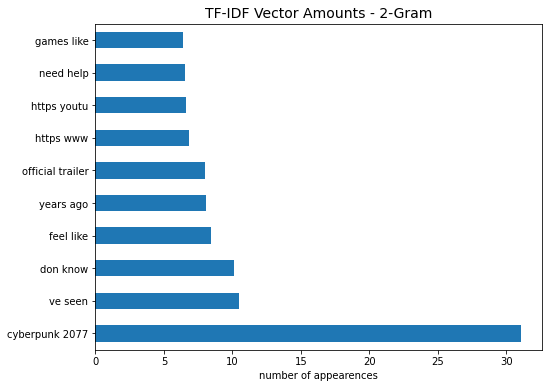

In [86]:
# Initialize TF-IDF object:
# N-gram range 2:
tfid = TfidfVectorizer(max_features=2000,stop_words='english',
                      ngram_range=(2,2))

# convert training data to dataframe for visual analysis of word vectors:
X_train_df = pd.DataFrame(tfid.fit_transform(X_train).todense(), 
                          columns=tfid.get_feature_names())

# plot top occuring words:
# Credit to Caroline Schmitt for Instruction:
plt.figure(figsize=(8,6))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('TF-IDF Vector Amounts - 2-Gram',size=14)
plt.xlabel('number of appearences',size=10);

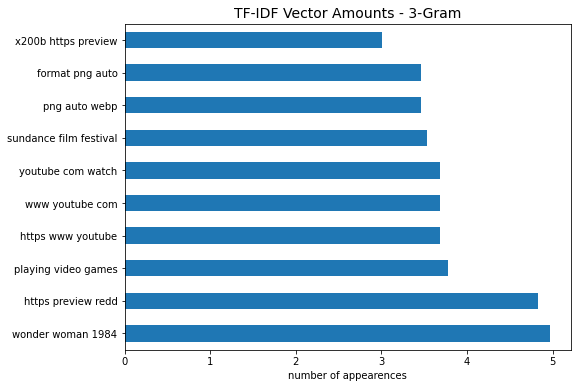

In [87]:
# N-gram range 3:
tfid = TfidfVectorizer(max_features=2000,stop_words='english',
                      ngram_range=(3,3))

X_train_df = pd.DataFrame(tfid.fit_transform(X_train).todense(), 
                          columns=tfid.get_feature_names())

# plot top occuring words:
plt.figure(figsize=(8,6))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('TF-IDF Vector Amounts - 3-Gram',size=14)
plt.xlabel('number of appearences',size=10);

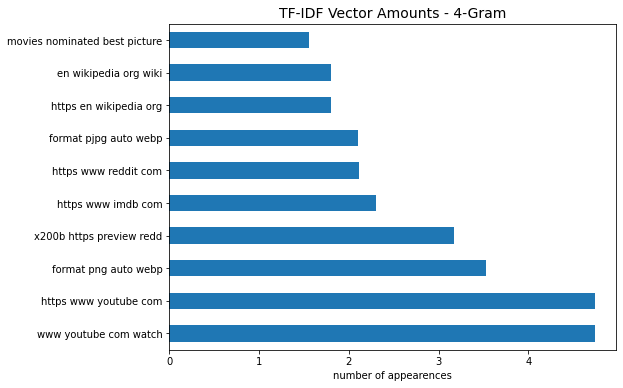

In [88]:
# N-gram range 4:
tfid = TfidfVectorizer(max_features=2000,stop_words='english',
                      ngram_range=(4,4))

X_train_df = pd.DataFrame(tfid.fit_transform(X_train).todense(), 
                          columns=tfid.get_feature_names())

# plot top occuring words:
plt.figure(figsize=(8,6))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('TF-IDF Vector Amounts - 4-Gram',size=14)
plt.xlabel('number of appearences',size=10);

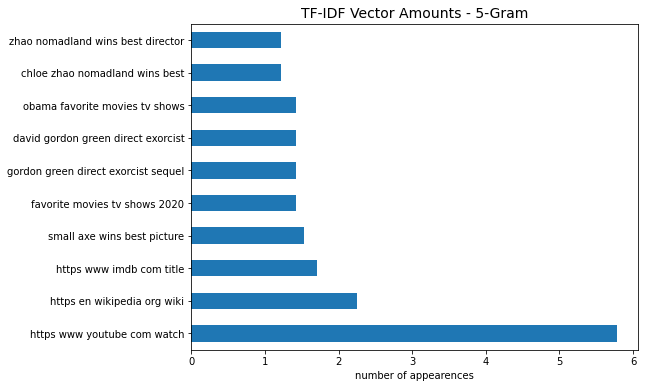

In [89]:
# N-gram range 5:
tfid = TfidfVectorizer(max_features=2000,stop_words='english',
                      ngram_range=(5,5))

X_train_df = pd.DataFrame(tfid.fit_transform(X_train).todense(), 
                          columns=tfid.get_feature_names())

# plot top occuring words:
plt.figure(figsize=(8,6))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('TF-IDF Vector Amounts - 5-Gram',size=14)
plt.xlabel('number of appearences',size=10);

In [90]:
# Display example of vectors:
X_train_df[X_train_df.columns[350:450]].head()

,pain villagers situation feel free,painful didn feel twice long,painful watch scene time feels,pains youth identified dawn degree,paint mario paint snes blast,paint snes blast thought wii,painting color ought ass removed,paints artistic fights adventurous spunky,pair cops investigating murder leto,pair nb oh boy neil,pair young best friends blonde,paired phenomenal actors marlon brando,pakistan british did care understand,pakistan centering fictional story brothel,pakistan partition hits incredibly hard,pal war worlds time machine,palace 10 paramedic turn terrorists,palace today 2020s dark gritty,palm hurt likely tendinitis pain,palm springs cow david byrne,palm tree makes laugh time,palma bonfire vanities turns 30,palma film massive budget means,palma lot talent begin wonder,palma trying satisfy commercial audiences,palma worst film coming mission,palmer starring justin timberlake official,pals romans makes john course,pam anderson tommy lee event,pam grier movies quintessential genre,pan hat entire movie information,pan labyrinth wow honestly blew,panasonic viera 2018 having real,pandemic changed temperature sci fi,pandemic closed theaters open attendance,pandemic covid 19 shuttered productions,pandemic movie theater industry isn,pandemic opinion watching humans evolve,pandemic pleased packaging did watch,pandemic pressure release 2020 resulted,pandemic provided rare opportunity success,pandemic relief funds employees went,pandemic think mcu movies just,pandemic thriller survivalist outbreak fbi,pandemic watching movies set beautiful,pandemic wife hated playing xbox,pandemic year holidays perfect thing,panel price range 350 400,panic jokes existence simply bizarre,panic kill turkey bare hands,pans old scary looking woman,pant notices start stupidly laugh,panther proved huge hollywood blockbuster,panther skin disrespectful chadwick boseman,pants black canvas shoes crimes,pants black canvas shoes red,pants grim forest curse unseen,pants required best cb2077 bug,paper character deaths comments original,paper characters time didn work,par course perk abusers hiring,para cold war sensitivity converter,para duty cold war sensibilidade,parade 1933 1h 42m comedy,parade 1948 1h 43m musical,parade 1955 25m 00am blue,parade 1955 25m 00am girl,parade 1955 25m 00pm charade,parade 1955 25m 00pm smiling,paradise 1932 1h 21m ernst,paradise people francesca trianni feature,paradoxically creating vast space viewer,paragraph suggestions send way enjoy,paramedic turn terrorists does happen,paramount dark horse transformers believe,paramount movies shooting disney half,paramount pictures smaller studios theres,parasite 2019 ending discussion spoilers,parasite father mr kim stays,parasite loved catalogue na hong,parasite really liked parasite loved,parasite saw trailer wish song,parasite snowpiercer easily popular films,parasite swept oscars keeping touch,parasite want dive deeper bong,pardon ignorance rtx latest cool,parent child feel like popular,parent child like dad used,parenting moment today daughter playing,parents bought beast 1992 mart,parents friends aren help thought,parents having divorce honestly tension,parents house xmas childhood code,parents mistreat embarrass aren shy,parents porn magazine stuff killed,parents remember set console christmas,parents remind younger believing lucky,parents sharlene whyte daniel francis,parents sister fucking terrifying felt,parents taking stepping dramatic conversations
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### EDA comparison with CountVectorizer:

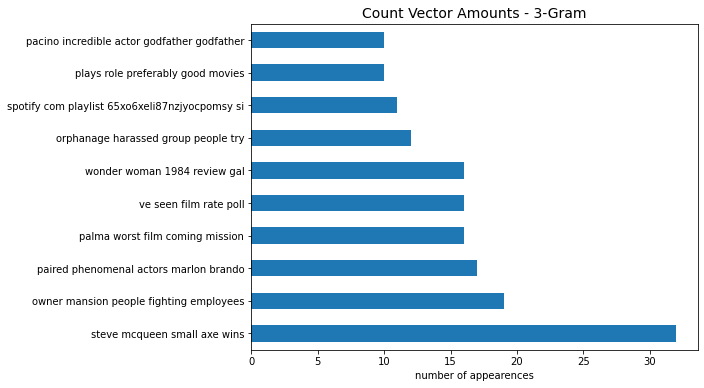

In [91]:
# Initialize TF-IDF object:
# N-gram range 2:

# Global variable set for n-gram range.
count = 3

cvec = CountVectorizer(max_features=2000,stop_words='english',
                      ngram_range=(count,count))

# convert training data to dataframe for visual analysis of word vectors:
X_train_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=tfid.get_feature_names())

# plot top occuring words:
# Credit to Caroline Schmitt for Instruction:
plt.figure(figsize=(8,6))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title(f'Count Vector Amounts - {count}-Gram',size=14)
plt.xlabel('number of appearences',size=10);

### Pipeline and GridSearch for Modeling:

In [92]:
# Initialize Pipeline:
pipe_tfid = Pipeline([
    ('tfid',TfidfVectorizer()),
    ('lr',LogisticRegression())
])

pipe_tfid_params = {
    'tfid__max_features':[2_000,3_000,4_000,5_000],
    'tfid__stop_words':[None,'english'],
    'tfid__ngram_range':[(1,1),(2,2),(3,3)]
}

# Initialize GridSearch - 5 Cross Validations:
gs_tfid = GridSearchCV(pipe_tfid,param_grid=pipe_tfid_params,cv=5) 

# Fit GridSearch
gs_tfid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tfid__max_features': [2000, 3000, 4000, 5000],
                         'tfid__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'tfid__stop_words': [None, 'english']})

In [93]:
# Display baseline accuracy:
y_test.value_counts(normalize=True)

1    0.509259
0    0.490741
Name: subreddit, dtype: float64

In [94]:
# Compare train and test accuracy scores
gs_tfid.score(X_train, y_train), gs_tfid.score(X_test, y_test)

(0.9953632148377125, 0.9305555555555556)

In [95]:
# GridSearch Results:
gs_tfid.best_params_

{'tfid__max_features': 4000,
 'tfid__ngram_range': (1, 1),
 'tfid__stop_words': 'english'}

In [96]:
gs_tfid.best_score_

0.9389392714974111

### Model Metrics:

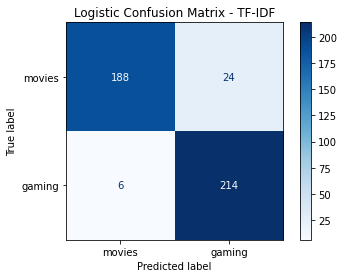

In [97]:
# Get predictions:
preds_tfid = gs_tfid.predict(X_test)

# Save confusion matrix values:
tn, fp, fn, tp = confusion_matrix(y_test,preds_tfid).ravel()

# Display Confusion Matrix:
plot_confusion_matrix(gs_tfid,X_test,y_test,cmap='Blues',
                      values_format='d',display_labels=['movies','gaming'])
plt.title('Logistic Confusion Matrix - TF-IDF');

In [98]:
# Display classification metrics:
print('precision: ',tp / (tp + fp))
print('sensitivity: ',tp / (tp + fn))
print('specificity: ',tn / (tn + fp))
print('accuracy: ',(tn + tp) / (tn + fp + fn + tp))

precision:  0.8991596638655462
sensitivity:  0.9727272727272728
specificity:  0.8867924528301887
accuracy:  0.9305555555555556


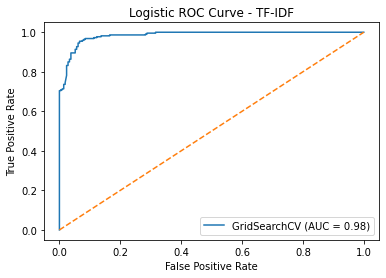

In [99]:
# Display ROC Curve:
plot_roc_curve(gs_tfid,X_test,y_test)
plt.plot([0,1],[0,1],
        label='baseline',linestyle='--')
plt.title('Logistic ROC Curve - TF-IDF')
plt.legend;

### CVEC Model Comparision:

In [100]:
# For evaluation if TF-IDF is a significant improvement above simple Count Vectorization:

# Pipeline & GridSearch

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

gs_cvec = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [101]:
# Compare train and test scores:
gs_cvec.score(X_train, y_train), gs_cvec.score(X_test, y_test)

(0.991499227202473, 0.9120370370370371)

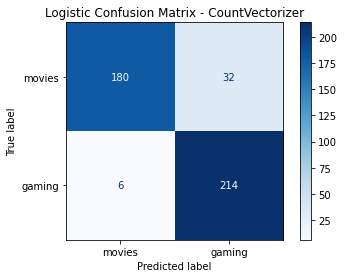

In [102]:
# Compare Metrics:
preds_cvec = gs_cvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec).ravel()

plot_confusion_matrix(gs_cvec,X_test,y_test,cmap='Blues',
                      values_format='d',display_labels=['movies','gaming'])
plt.title('Logistic Confusion Matrix - CountVectorizer');

In [103]:
print('precision: ',tp / (tp + fp))
print('sensitivity: ',tp / (tp + fn))
print('specificity: ',tn / (tn + fp))
print('accuracy: ', (tn + tp) / (tn + fp + fn + tp))

precision:  0.8699186991869918
sensitivity:  0.9727272727272728
specificity:  0.8490566037735849
accuracy:  0.9120370370370371


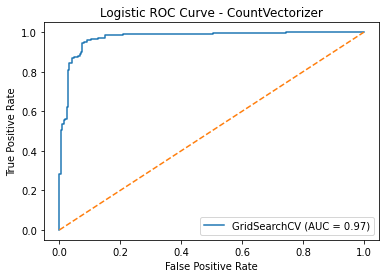

In [104]:
plot_roc_curve(gs_cvec,X_test,y_test)
plt.plot([0,1],[0,1],
        label='baseline',linestyle='--')
plt.title('Logistic ROC Curve - CountVectorizer')
plt.legend;

In [105]:
# Restate baseline accuracy:
y_test.value_counts(normalize=True)

1    0.509259
0    0.490741
Name: subreddit, dtype: float64

In [106]:
# GirdSearch results:
gs_cvec.best_score_

0.9304420699769537

In [107]:
gs_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [108]:
gs_tfid.best_params_

{'tfid__max_features': 4000,
 'tfid__ngram_range': (1, 1),
 'tfid__stop_words': 'english'}